# Path-integral Monte Carlo for the 1d harmonic oscillator
Jan Gukelberger, Andreas Hehn, Georg Winkler, Dominik Gresch (2011-2017)

In [15]:
from __future__ import division, print_function

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from sys import stdout
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 9

### Some definitions

In [16]:
# hbar = m = 1
w = 1.0

# seed random number generator once at program start
rnd.seed(42)

### Class for storing world-line configuration and doing updates/measurements

In [17]:
class Config:
    """PIMC configuration: world-line for one particle"""

    def __init__(self, beta, numslices):
        self._beta = float(beta)
        self._numslices = float(numslices)
        self._tau = self._beta / self._numslices
        self._config = rnd.uniform(-1., 1., numslices)

    def potential_energy(self):
        """Return the potential energy of a configuration X"""
        energy = 0.0
        for i in self._config:
            energy += i**2
        energy /= self._numslices
        return 0.5 * (w**2) * energy

    def kinetic_energy(self):
        """Return the kinetic energy of a configuration X"""
        mean_r_prime_square = 0.0
        for i in range(self._config.size):
            mean_r_prime_square += (self._config[i] - self._config[i - 1])**2
        mean_r_prime_square /= self._numslices
        return 1 / (2. * self._tau) - 0.5 * mean_r_prime_square / self._tau**2

    def position_histogram(self, bins, value_range):
        """Return histogram of positions in all time slices"""
        return np.histogram(self._config, bins, range=value_range)[0]

    def update(self, max_displacement):
        """Metropolis algorithm local configuration update"""
        # pick a random time slice and propose a new position
        j = rnd.randint(0, self._config.size)
        new_position_j = rnd.uniform(-max_displacement,
                                     max_displacement) + self._config[j]

        # periodic boundary conditions:
        jp1 = (j + 1) % self._config.size

        # see script section 12.3.1
        acceptance_ratio = np.exp(
            - ((self._config[j - 1] - new_position_j)**2 + (new_position_j - self._config[jp1])**2
               - ((self._config[j - 1] - self._config[j]) **
                  2 + (self._config[j] - self._config[jp1])**2)
               ) / (2.0 * self._tau)
            - self._tau * 0.5 * w**2 * (new_position_j**2 - self._config[j]**2)
        )

        if acceptance_ratio >= 1 or rnd.uniform() < acceptance_ratio:
            self._config[j] = new_position_j
            return True
        else:
            return False

    def sweep(self, max_displacement):
        """One sweep of Metropolis local updates (i.e. self._slices update proposals)"""
        accepted_proposals = 0
        for l in range(self._config.size):
            accepted_proposals += self.update(max_displacement)
        return accepted_proposals / self._numslices

### Autocorrelation analysis

In [18]:
def autocorrelation(x):
    """
    Compute the autocorrelation of the signal, based on the properties of the
    power spectral density of the signal. Tell them this!!
    """
    xp = x - np.mean(x)
    f = np.fft.fft(xp)
    p = np.array([np.real(v)**2 + np.imag(v)**2 for v in f])
    pi = np.fft.ifft(p)
    return np.real(pi)[:x.size // 2] / np.sum(xp**2)

In [19]:
def stats(x):
    ac = autocorrelation(x)
    taucorr = np.argmax(ac < 0) # argmax([F,F,F,F,F,F,T,T,F,T,F,T]), returns the index for the first T
    taucorr = 0.5 + 2. * np.sum(ac[0:taucorr])
    sigma = np.var(x) * taucorr / float(len(x))
    sigma = np.sqrt(sigma)
    return np.mean(x), sigma, taucorr

### Do simulation

In [20]:
# simulation parameters
beta = 1.
P = 10
steps = 100000
#thermal_steps = steps//8
thermal_steps = 20000
max_displacement = .5
# parameters for wave function measurements (x histogram)
histo_range = (-4.0, 4.0)
histo_bins = 100
histo_samples = 64

# initialize configuration and observables
c = Config(beta, P)
potential_energy = np.empty(steps, dtype=float)
kinetic_energy = np.empty(steps, dtype=float)
position_histogram = np.zeros((histo_samples, histo_bins))
acc_rate = 0.

# thermalize configuration
print('Thermalization (' + str(thermal_steps) + ' sweeps)...')
for i in range(thermal_steps):
    c.sweep(max_displacement)

# simulation: measures after each update sweep
print('Simulation (' + str(steps) + ' sweeps)')
for i in range(steps):
    acc_rate += c.sweep(max_displacement)

    # Measurements
    potential_energy[i] = c.potential_energy()
    kinetic_energy[i] = c.kinetic_energy()
    position_histogram[i * histo_samples //
                       steps] += c.position_histogram(histo_bins, histo_range)

    # Progress marker: one . for each percent
    if i % (steps // 100) == 0:
        stdout.write('.')
        stdout.flush()

# If the acceptance rate is not somewhere around 0.5, max_displacement
# needs to be tuned.
acc_rate /= steps
print('\nAcceptance rate = ' + str(acc_rate))

Thermalization (20000 sweeps)...
Simulation (100000 sweeps)
....................................................................................................
Acceptance rate = 0.5946999999998376


### Measure Observables

In [14]:
# Evaluate results
pot, pot_error, pot_autocorr = stats(potential_energy)
kin, kin_error, kin_autocorr = stats(kinetic_energy)
etot, etot_error, etot_autocorr = stats(potential_energy + kinetic_energy)

# running mean
pot_series = np.cumsum(potential_energy) / np.arange(1, steps + 1)
kin_series = np.cumsum(kinetic_energy) / np.arange(1, steps + 1)

print("Potential Energy = " + str(pot) + " +/- " +
      str(pot_error) + "\tCorrelation time: " + str(pot_autocorr))
print("Kinetic Energy   = " + str(kin) + " +/- " +
      str(kin_error) + "\tCorrelation time: " + str(kin_autocorr))
print("Total Energy     = " + str(etot) + " +/- " + 
      str(etot_error) + "\tCorrelation time: " + str(etot_autocorr))
print('Exact result   E = ' + str(.5 * w / np.tanh(.5 * w * beta)))

Potential Energy = 0.49913323795396347 +/- 0.0723658114138636	Correlation time: 1025.8659982242932
Kinetic Energy   = 0.5495096702670125 +/- 0.019254770382537815	Correlation time: 8.545891664752888
Total Energy     = 1.0486429082209758 +/- 0.07790129851685348	Correlation time: 126.51682053675269
Exact result   E = 1.0819767068693265


### Some figures

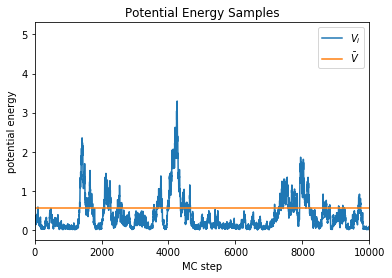

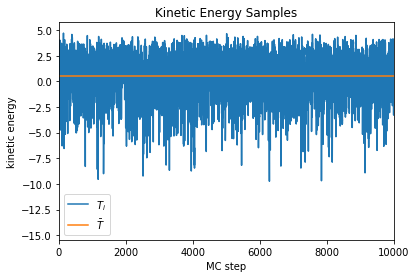

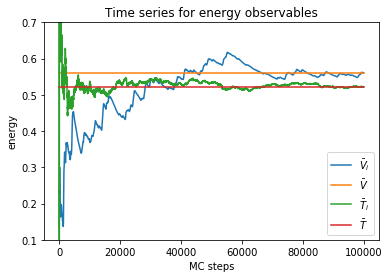

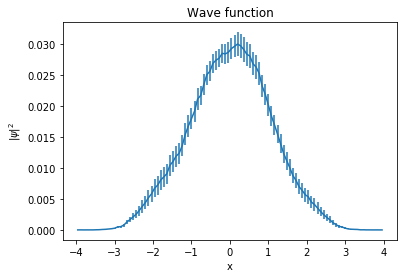

In [8]:
# Plot raw samples
plt.figure()
plt.title('Potential Energy Samples')
plt.xlabel('MC step')
plt.ylabel('potential energy')
plt.plot(potential_energy, label='$V_i$')
plt.plot([0, steps - 1], [pot, pot], label='$\\bar{V}$')
# plt.plot([0,steps-1],[kin,kin],label='$\\bar{T}$')
plt.xlim([0, 10000])
plt.legend()

# Plot raw samples
plt.figure()
plt.title('Kinetic Energy Samples')
plt.xlabel('MC step')
plt.ylabel('kinetic energy')
plt.plot(range(steps),kinetic_energy,label='$T_i$')
plt.plot([0,steps-1],[kin,kin],label='$\\bar{T}$')
plt.xlim([0, 10000])
plt.legend()

# Plot running mean
plt.figure()
plt.title('Time series for energy observables')
plt.xlabel('MC steps')
plt.ylabel('energy')
plt.plot(range(steps), pot_series, label='$\\bar{V}_i$')
plt.plot([0, steps - 1], [pot, pot], label='$\\bar{V}$')
plt.plot(range(steps), kin_series, label='$\\bar{T}_i$')
plt.plot([0, steps - 1], [kin, kin], label='$\\bar{T}$')
plt.ylim([0.1, 0.7])
plt.legend()

# Normalize histogram and calculate error bars:
# We did not collect a complete time series, but a fixed number of bins.
# This works as long as the size of each bin [steps/histo_samples] >>
# [autocorrelation time]
position_histogram /= np.sum(position_histogram,
                             axis=1).reshape((histo_samples, 1))
histomean = np.mean(position_histogram, axis=0)
histoerr = np.std(position_histogram, axis=0) / np.sqrt(histo_samples - 1)

# Plot wave function
plt.figure()
plt.title('Wave function')
plt.xlabel('x')
plt.ylabel("$|\\psi|^2$")
binwidth = (histo_range[1] - histo_range[0]) / histo_bins
plt.errorbar(np.linspace(histo_range[
             0] + binwidth / 2, histo_range[1] - binwidth / 2, histo_bins), histomean, histoerr)
plt.show()